#### Import Interpretable Machine Learning LIB||

In [1]:
import tensorflow as tf
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input, decode_predictions
from alibi.datasets import load_cats
from alibi.explainers import AnchorImage

C:\Users\jwst2\anaconda3\envs\datasc\lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


In [2]:
import fastai
from fastai.vision.all import *
import pandas as pd

In [3]:
from PIL import Image
import PIL

In [4]:
import torchvision.transforms as T

In [5]:
from IPython.display import clear_output

In [173]:
import seaborn as sns

##### Metode untuk Anchor Intrepreter 

In [ ]:
def explain_ur(explainer,path, pval = 0.9 , nseg= 9):
    image_shape = (224, 224,3)
    segmentation_fn = 'slic'
    kwargs = {'n_segments': nseg, 'compactness': 20, 'sigma': .5}
    explainer = AnchorImage(predict_fn, image_shape, segmentation_fn=segmentation_fn,
                                segmentation_kwargs=kwargs, images_background=None)
    img_pil = Image.open(path)
    img_pil = np.asarray(img_pil)
    fig, ax = plt.subplots(1, 3,figsize=(15,15))
    explanation = explainer.explain(img_pil, threshold=pval, p_sample=1)
    clear_output(wait=True)
    ax[0].imshow(img_pil)
    ax[0].title.set_text(sls[sls.iddesa == int((path)[-14:-4])]["nmdesa"].to_list()[0]+" ("+model.predict(PILImage.create(path))[0]+")")
    ax[1].imshow(explanation.anchor)
    ax[1].title.set_text("Anchor (P ="+str(pval)+")")
    ax[2].imshow(explanation.segments)
    ax[2].title.set_text("N Segments (slic) : "+str(nseg))

##### Metode untuk Explainable dengan NDVI untuk Vegetasi dan Softmax Probability

In [43]:
def plot_vegur(name):
    fig, ax = plt.subplots(1, 2,figsize=(15,15))
    img_pil1 = Image.open(imagepath+name+".jpg")
    img_pil2 = Image.open(imagepathnd+name+".jpg")
    ax[0].imshow(img_pil1)
    ax[0].title.set_text(sls[sls.iddesa == int(name)]["nmdesa"].to_list()[0]+" (sfmx rural : "+str(model.predict(PILImage.create(imagepath+name+".jpg"))[2].numpy()[0])+")")
    ax[1].imshow(img_pil2)
    ax[1].title.set_text("Vegetation Percentage = "+str(greenCalculator(imagepathnd+name+".jpg"))+")")



##### Metode Penghitungan persentase vegetasi

In [141]:
def greenCalculator(path):
    # Load image and convert to HSV
    im = Image.open(path).convert('HSV')
    # Extract Hue channel and make Numpy array for fast processing
    Hue = np.array(im.getchannel('H'))
    # Make mask of zeroes in which we will set greens to 1
    mask = np.zeros_like(Hue, dtype=np.uint8) 
    # Set all green pixels to 1
    mask[(Hue>60) & (Hue<120)] = 1 
    # Now print percentage of green pixels
    return (mask.mean()*100)

Buka model terbaik

In [89]:
datapath = "C:/Users/jwst2/Python/tesis/jpg/UR/10. Sentinel 10M Desa ES/"
modelpath = "C:/Users/jwst2/Python/tesis/models/18042022 D010.pkl"
imagepath = "C:/Users/jwst2/Python/tesis/jpg/general desa sentinel ES/"
imagepath2 = "C:/Users/jwst2/Python/tesis/jpg/general desa sentinel 10m tc/"
imagepathnd = "C:/Users/jwst2/Python/tesis/jpg/general ndvi desa ES/"

In [6]:
path2img = 'C:/Users/jwst2/Python/tesis/jpg/general desa sentinel ES/3201140006.jpg'

In [8]:
img = PILImage.create(path2img)

In [9]:
image_shape = (224, 224, 3)
data, labels = load_cats(target_size=image_shape[:2], return_X_y=True)
print(f'Images shape: {data.shape}')

Images shape: (4, 224, 224, 3)


In [90]:
model = load_learner(modelpath)

Membentuk anchor

In [11]:
def predict_fn(x):
    z = x[0].astype(np.uint8)
    z = PILImage.create(z)
    output = model.predict(z)[2].numpy()
    for i in range(1,x.shape[0]):
        y = x[i].astype(np.uint8)
        y = PILImage.create(y)
        output = np.append(output,model.predict(y)[2].numpy(),axis= 0)
    return output.reshape(-1, 2)

#### Interpretasi dengan menggunakan Anchor

In [22]:
model.predict(PILImage.create(imagepath+"3210030028.jpg"))

('urban', TensorBase(1), TensorBase([0.4013, 0.5987]))

In [78]:
sls = pd.read_csv("C:/Users/jwst2/Python/tesis/dataset/3200_sls.csv")

Columns (19,20,21,22) have mixed types. Specify dtype option on import or set low_memory=False.


In [79]:
desa = sls.groupby(["iddesa"]).agg({
    'j_kk' : sum,
    'j_bstt' :sum,
    'j_bsbtt' :sum,
    'j_bstt_k' :sum,
    'luas' :sum,
     'klas_ur' : max,
    
})

In [80]:
desa["jumlah_bangunan"] = desa["j_bstt"]+desa["j_bsbtt"]+desa["j_bstt_k"]

In [81]:
path = path2img

In [82]:
sls[sls.iddesa == int((path)[-14:-4])]["nmdesa"].to_list()[0]

'CITARINGGUL'

Keputusan manusia dalam melakukan klasifikasi desa urban dan rural sesuai dengan definisi dari daerah perkotaan. Tiga faktor yang menjadi komponen penentuan klasifikasi tersebut adalah kepadatan penduduk per km2, persentase keluarga pertanian, dan keberadaan/akses ke fasilitas perkotaan. Fasilitas yang dimaksud adalah sekolah, pasar, kelompok pertokoan, rumah sakit, hotel/bilyar/diskotek/panti pijat/salon, persentase keluarga dengan telepon kabel, dan persentase keluarga yang menggunakan listrik PLN.
Desa dengan kepadatan penduduk tinggi mendapatkan penilaian lebih pada penentuan sebuah desa sebagai desa urban. Komponen tersebut sejalan dengan Anchor yang didapatkan dari model deep learning untuk kelas urban di mana segmen dengan berkepadatan bangunan tinggi memberikan 90% presisi dalam penentuan kelas urban seperti pada Gambar 19. Hal ini menunjukkan ada kesamaan satu sisi pengambilan keputusan antara manusia (kepadatan penduduk) dan model deep learning (kepadatan bangunan) dalam menentukan klasifikasi.


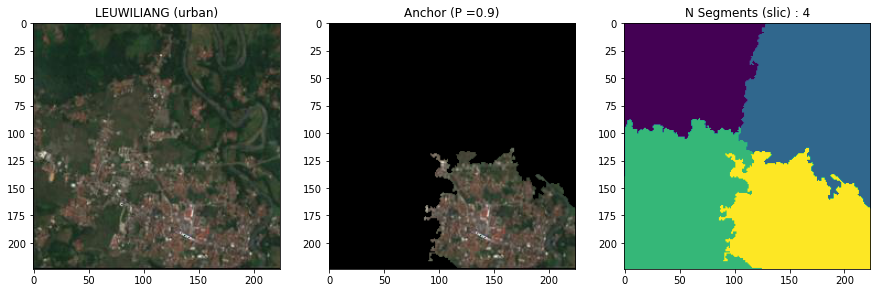

In [58]:
explain_ur(explainer,imagepath +'3201020018.jpg',nseg= 4)

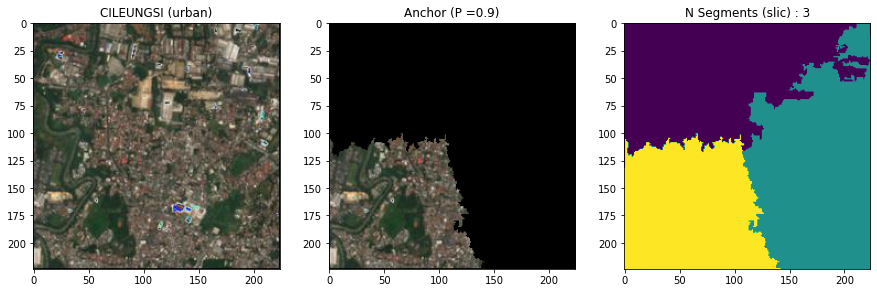

In [59]:
explain_ur(explainer,imagepath +'3201180018.jpg',nseg = 3)

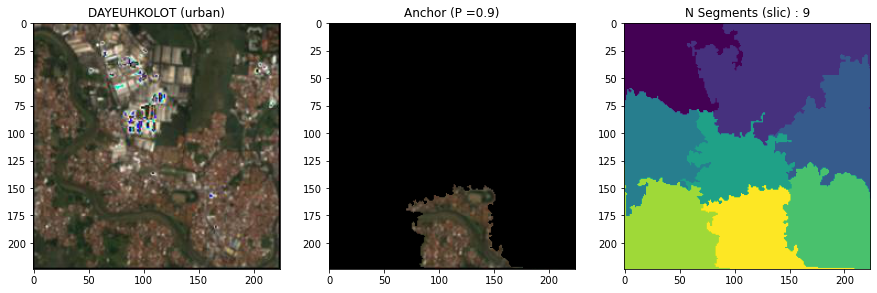

In [60]:
explain_ur(explainer,imagepath+ '3204270004.jpg')

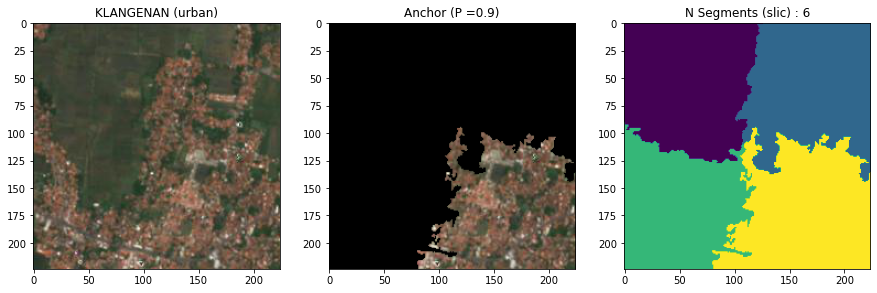

In [76]:
explain_ur(explainer,imagepath +'3209190002.jpg',nseg = 6)

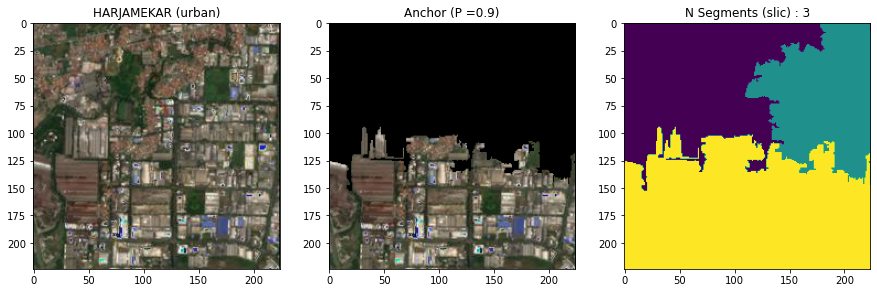

In [65]:
explain_ur(explainer,imagepath +'3216061002.jpg',nseg = 3)

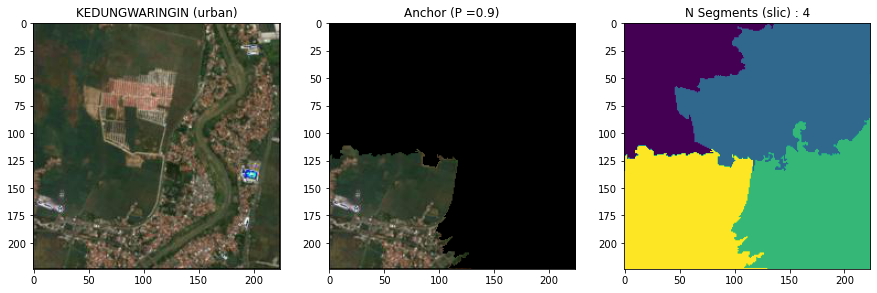

In [74]:
explain_ur(explainer,imagepath +'3216050003.jpg',nseg = 4)

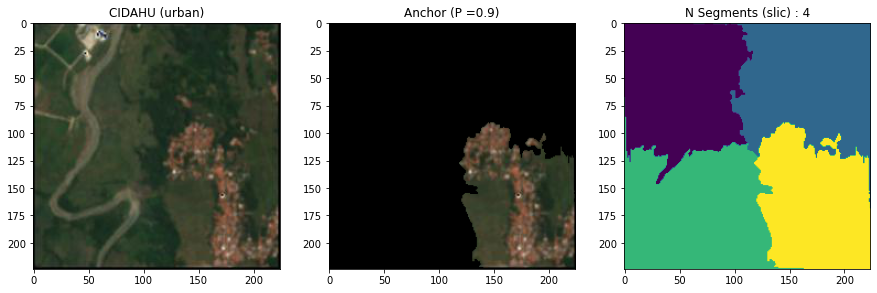

In [72]:
explain_ur(explainer,imagepath +'3214090010.jpg',nseg = 4)

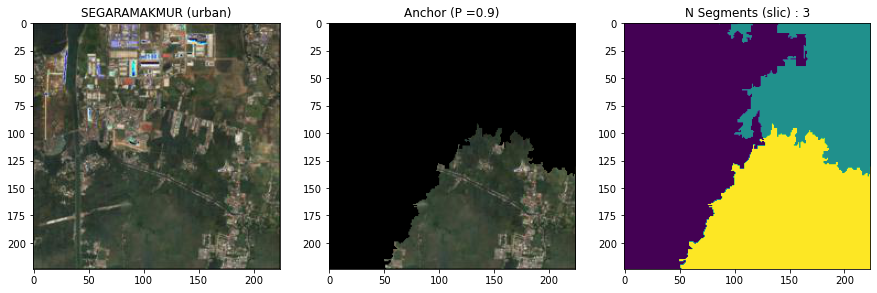

In [73]:
explain_ur(explainer,imagepath +'3216100005.jpg',nseg = 3)

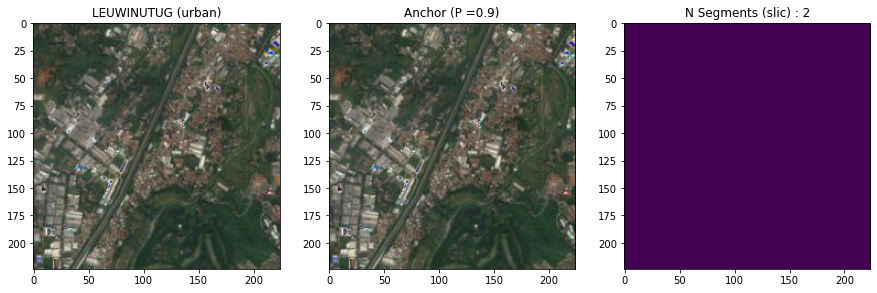

In [79]:
explain_ur(explainer,imagepath +'3201200006.jpg',nseg = 2)

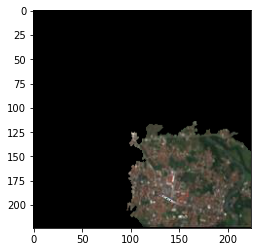

In [189]:
plt.imshow(explanation.anchor);

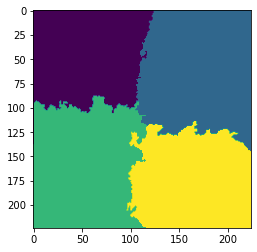

In [190]:
plt.imshow(explanation.segments);

In [254]:
image_shape = (224, 224,3)
segmentation_fn = 'slic'
kwargs = {'n_segments': 4, 'compactness': 20, 'sigma': .5}
explainer = AnchorImage(predict_fn, image_shape, segmentation_fn=segmentation_fn,
                        segmentation_kwargs=kwargs, images_background=None)

In [310]:
path2imgr = imagepath +'3203090003.jpg'
img_pilr = Image.open(path2imgr)
img_pilr = np.asarray(img_pilr)

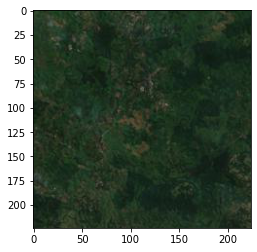

In [311]:
plt.imshow(img_pilr);

In [312]:
model.predict(PILImage.create(path2imgr))

('rural', tensor(0), tensor([0.5338, 0.4662]))

In [298]:
path2imgr = imagepath +'3205010010.jpg'
img_pilr = Image.open(path2imgr)
img_pilr = np.asarray(img_pilr)

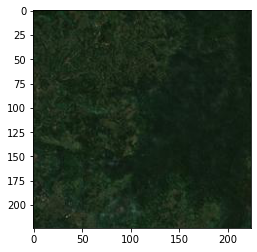

In [299]:
plt.imshow(img_pilr);

In [300]:
model.predict(PILImage.create(path2imgr))

('rural', tensor(0), tensor([0.8055, 0.1945]))

In [339]:
path2imgr = imagepath +'3202110014.jpg'
img_pilr = Image.open(path2imgr)
img_pilr = np.asarray(img_pilr)

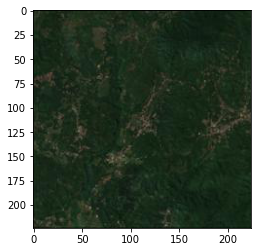

In [340]:
plt.imshow(img_pilr);

In [341]:
model.predict(PILImage.create(path2imgr))

('urban', tensor(1), tensor([0.3386, 0.6614]))

In [338]:
path2imgr = imagepath +'3203051008.jpg'
img_pilr = Image.open(path2imgr)
img_pilr = np.asarray(img_pilr)

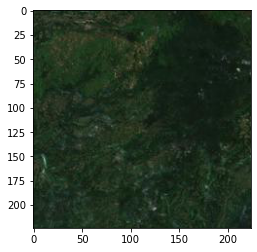

In [320]:
plt.imshow(img_pilr);

#### Interpretasi dengan NDVI Vegetasi

Komponen kedua keputusan manusia dalam klasifikasi adalah mempertimbangkan banyaknya rumah tangga pertanian sebagai indikator untuk menentukan desa sebagai desa rural.  Variabel tersebut tidak dapat dilihat langsung pada citra. Untuk itu dilakukan pendekatan lain dengan mengasumsikan jumlah persentase keluarga pertanian dapat didekati dengan jumlah persentase vegetasi di suatu wilayah. Di mana, Semakin banyak vegetasi di suatu wilayah, lebih banyak keluarga pertanian yang tinggal di wilayah tersebut. Untuk menghitung persentase vegetasi di dalam sebuah citra digunakan NDVI untuk mengklasifikasikan wilayah vegetasi dan non vegetasi pada citra. Hasil klasifikasi wilayah vegetasi disimbolkan dengan warna hijau dan non vegetasi disimbolkan dengan warna merah . Kemudian, citra RGB dikonversi ke nilai HSV untuk menghitung persentase warna hijau dalam suatu citra dengan memanfaatkan nilai Hue.

In [150]:
import seaborn as sns

In [74]:
name = "3210070002"

In [145]:
model.predict(PILImage.create(imagepath+"3216071005"+".jpg"))

('urban', TensorBase(1), TensorBase([0.0319, 0.9681]))

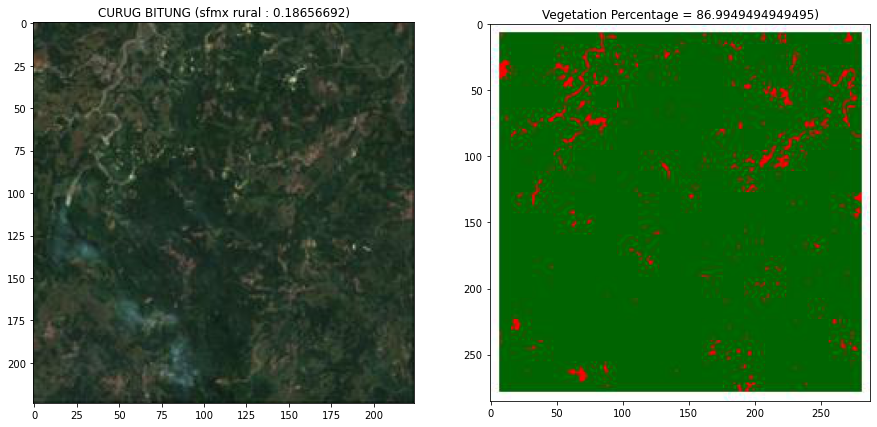

In [150]:
plot_vegur("3201010004")

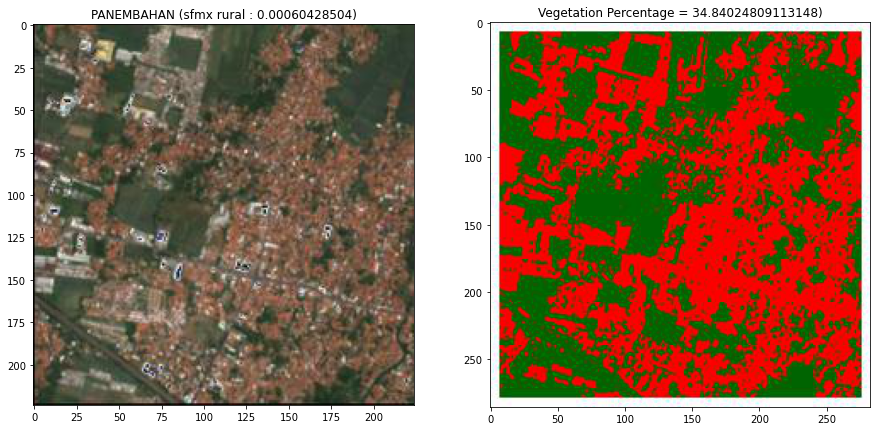

In [143]:
plot_vegur("3209151001")

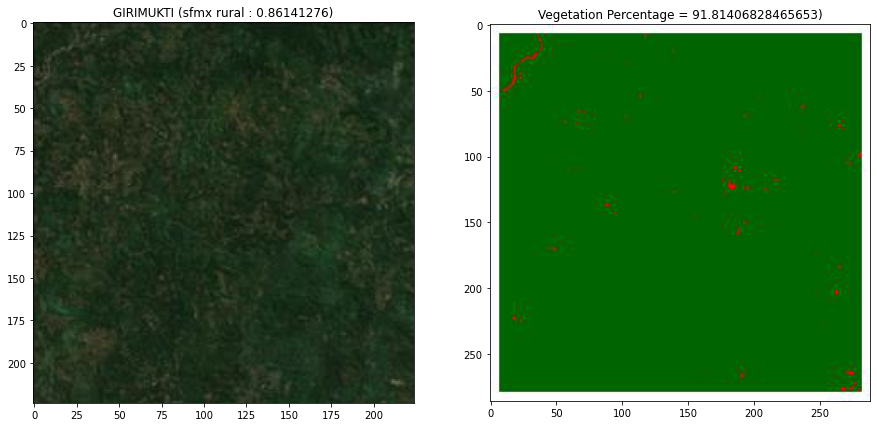

In [144]:
plot_vegur("3205060009")

#### Perbandingan softmax dan persentase vegetasi

In [99]:
desarural = desa

In [100]:
pd.reset_option('mode.chained_assignment')
with pd.option_context('mode.chained_assignment', None):
    desarural["softmaxrural"] = 0.0

In [101]:
from tqdm import tqdm

In [103]:
for i in desarural.index.to_list():
    desarural.softmaxrural[desarural.index == i] = model.predict(PILImage.create(imagepath+str(i)+".jpg"))[2].numpy()[0]
    clear_output(wait=True)

In [105]:
desarural.to_csv("C:/Users/jwst2/Python/tesis/dataset/probur.csv")

##### Green Index

In [146]:
desarural = pd.read_csv("C:/Users/jwst2/Python/tesis/dataset/probur.csv")

In [ ]:
desarural["klas_ur_pred"] = 0
desarural.klas_ur_pred[desarural.softmaxrural >0.5] = 2
desarural.klas_ur_pred[desarural.softmaxrural <=0.5] = 1

In [152]:
desarural["greenindex"] = 0.0

In [154]:
for i in desarural.iddesa.to_list():
    desarural.greenindex[desarural.iddesa == i] = greenCalculator(imagepathnd+str(i)+".jpg")


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [155]:
desarural = desarural.to_csv("C:/Users/jwst2/Python/tesis/dataset/probur_fin.csv")

#### True PositiveCut

In [156]:
desarural = pd.read_csv("C:/Users/jwst2/Python/tesis/dataset/probur_fin.csv")

In [157]:
desarural.sort_values("softmaxrural").tail(10)

,Unnamed: 0,iddesa,j_kk,j_bstt,j_bsbtt,j_bstt_k,luas,klas_ur,jumlah_bangunan,softmaxrural,klas_ur_pred,greenindex
504,504,3202060005,1426,1298,159,53,5.586817e+07,2,1510,0.830245,2,90.225628
1480,1480,3205020005,1839,1726,114,25,3.201531e+07,2,1865,0.831617,2,92.800602
493,493,3202050001,1780,1728,164,84,1.993914e+07,2,1976,0.833077,2,91.826466
827,827,3203010009,724,697,36,41,1.580379e+07,2,774,0.835573,2,90.010684
495,495,3202050003,1984,1830,220,30,1.543900e+07,1,2080,0.836540,2,87.260301
490,490,3202041004,1499,1405,114,70,1.046239e+07,2,1589,0.840915,2,89.182768
510,510,3202070003,1793,1717,43,34,3.278865e+07,2,1794,0.844346,2,80.640540
505,505,3202060006,1062,1015,94,15,3.463815e+07,2,1124,0.859861,2,91.720475
1527,1527,3205060009,832,810,58,7,2.350248e+07,2,875,0.861413,2,91.814068
498,498,3202050006,1460,1414,75,23,2.225800e+07,2,1512,0.862137,2,87.653810


In [167]:
desarural["pname"] = "rural"
desarural.pname[desarural.klas_ur_pred == 1] = "urban"


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Setelah didapatkan persentase vegetasi untuk setiap desa, nilai tersebut dihubungkan dengan prediksi model deep learning. Gambar 21 menunjukkan model memprediksi desa rural dengan mempertimbangkan nilai vegetasi, dimana desa yang diprediksi rural cenderung desa yang memiliki persentase vegetasi yang lebih tinggi. Sehingga disimpulkan terdapat kesamaan pengambilan keputusan antara manusia dan model dari sisi persentase keluarga tani.

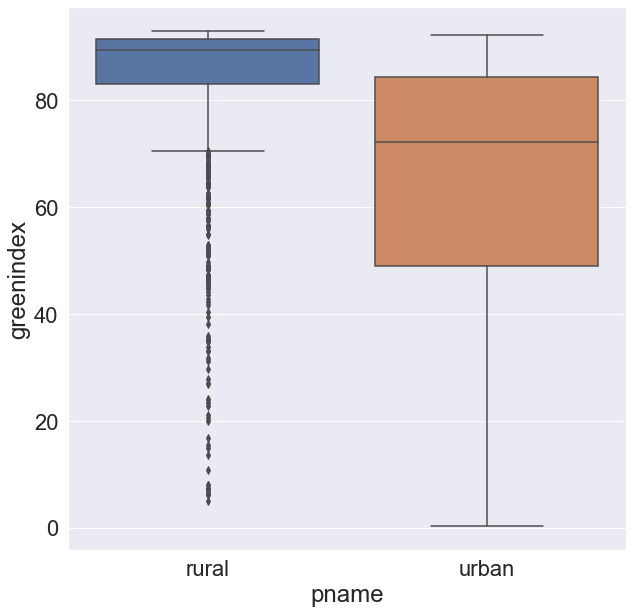

In [218]:
sns.set(rc={'figure.figsize':(10,10)})
sns.set(font_scale = 2)
ax = sns.boxplot(x="pname", y="greenindex", data=desarural)


In [174]:
desaruralcut = desarural

In [175]:
desaruralcut["jb_percet"] = (desaruralcut["jumlah_bangunan"])/desaruralcut.luas

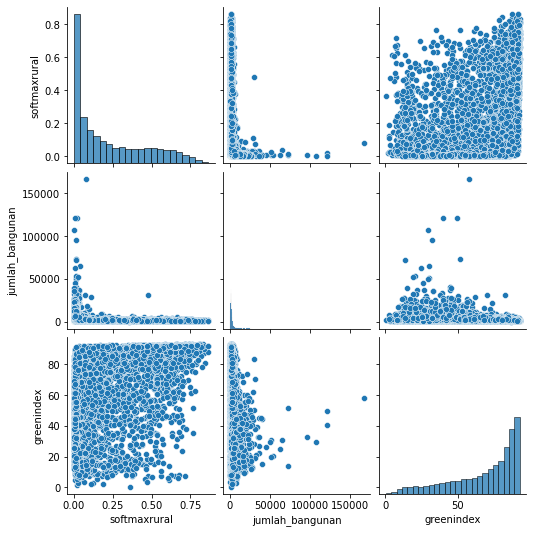

In [177]:
sns.pairplot(desaruralcut[["softmaxrural","jumlah_bangunan","greenindex"]])


In [188]:
desaruralcut["vegetation_percetage"] = desaruralcut["greenindex"] 

In [189]:
mask = np.zeros_like(desaruralcut[["softmaxrural","vegetation_percetage"]].corr())
mask[np.triu_indices_from(mask)] = True


Asumsi : human desicion mempertimbangkan banyaknya rumah tangga pertanian sebagai indikator untuk menentukan desa sebagai desa rural.  Sehingga diasumsikan jumlah persentase keluarga pertanian dapat didekati dekati dengan jumlah persentase vegetasi disuatu wilayah. Dimana, Semakin banyak vegetasi di suatu wilayah, lebih banyak keluarga pertanian di wilayah tersebut.

Hasil : model memprediksi desa rural dengan mempertimbangkan nilai vegetasi, di mana desa yang diprediksi rural cenderung desa yang memiliki presentase vegetasi yang lebih tinggi. Sehingga dapat disimpulkan model mempelajari ”rumah tangga pertanian”  melalaui hal tersebut.


<AxesSubplot:>

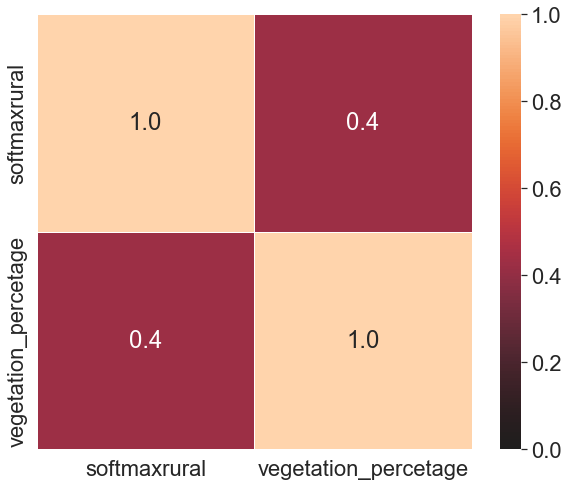

In [219]:
fig, ax = plt.subplots( figsize=(10,8) )
sns.heatmap(desaruralcut[["softmaxrural","vegetation_percetage"]].corr(),
            annot=True, center=0,
            linewidths=.5, square=True,
            vmin=0, vmax=1, fmt='0.1f')

### MOST Confused

In [119]:
from alibi.confidence import TrustScore

In [23]:
path = Path.cwd() / (datapath)
blocks = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files, # finds the images in the path
                 splitter=RandomSplitter(valid_pct=0.1, seed=42),  # default random split 80% training, 20% validation
                 get_y=parent_label,item_tfms = Resize(224)) # data augmentation (mult multiplies the default transformation values)
dls = blocks.dataloaders(path,bs=4)

Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `number_workers` is changed to 0 to avoid getting stuck


In [26]:
model.dls.train = dls.train
model.dls.valid = dls.valid

In [ ]:
preds,_ = model.get_preds()

In [ ]:
interp.plot_top_losses(16)

In [ ]:
interp = ClassificationInterpretation.from_learner(model)